# basic Network

In [1]:
#imports
import tensorflow as tf
import numpy as np
#tf.reset_default_graph()
import matplotlib.pyplot as plt
#get_ipython().magic('matplotlib inline')
from os import system
from helpers import lazy_property
#from datasets import unison_shuffled_copies

from global_vars import ADVERSARIAL


import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_regression


n_samples = 200
seed = 50

num_epochs = 5
num_meta_epochs = 10 #also numplots
learning_rate = 1/num_epochs


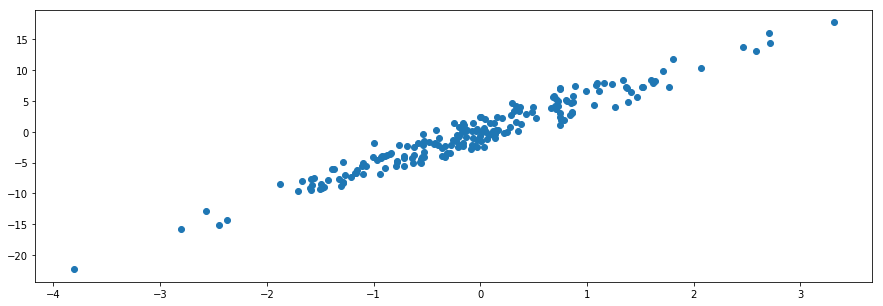

In [2]:
#Dataset
X, y = make_regression(n_samples=200, n_features=1, noise=15,random_state=seed,shuffle=True)#,n_informative=1,bias=100)
y = y/10 #+ 10

num_neurons = [10,10]
plt.scatter(X,y)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=420,shuffle=True)
train_idx = np.argsort(X_train,axis=0).squeeze()
test_idx = np.argsort(X_test,axis=0).squeeze()

In [4]:
# Create a random dataset
rng = np.random.RandomState(seed)
X_nonlinear = np.sort(9 * rng.rand(n_samples, 1), axis=0)
y_nonlinear =  np.sin(X_nonlinear).ravel()*10 + np.random.normal(0,1,size=X_nonlinear.shape[0])# + 10

## Predict
#X_test_nonlinear = np.arange(-1.0, 12, 0.1)[:, np.newaxis] 
#y_test_nonlinear =  np.sin(X_test_nonlinear).ravel()*10 + np.random.normal(0,3,size=X_test_nonlinear.shape[0])

X_train_nonlinear, X_test_nonlinear, y_train_nonlinear, y_test_nonlinear = train_test_split(X_nonlinear, y_nonlinear, test_size=0.3, random_state=420,shuffle=True)
train_idx_nonlinear = np.argsort(X_train_nonlinear,axis=0).squeeze()
test_idx_nonlinear = np.argsort(X_test_nonlinear,axis=0).squeeze()




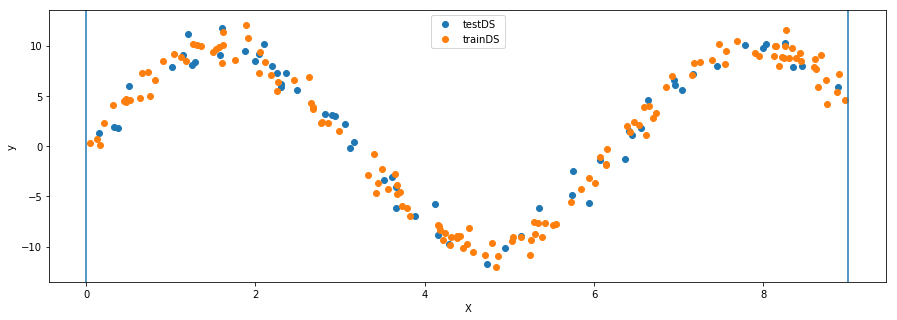

In [5]:
plt.scatter(X_test_nonlinear,y_test_nonlinear,label='testDS')
plt.scatter(X_train_nonlinear,y_train_nonlinear,label='trainDS')
plt.xlabel('X')
plt.ylabel('y')
#plt.savefig('nonlinearDataset.png')
plt.axvline(x=9)
plt.axvline(x=0)
plt.legend()


# Visualisation + training


In [6]:


def visualise(net,num_meta_epochs=num_meta_epochs,plot=False,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,test_idx=test_idx,train_idx=train_idx):

    y_pred = net.predict(X_test)
    #try: y_pred[1]
    #except:
    #        y = y_pred[0]

    if plot:
        fig = plt.figure(figsize=(20,5*num_meta_epochs+1))
        fig.add_subplot(num_meta_epochs+1,1,1)
        plt.plot(X_test[test_idx],y_pred[test_idx],c='orange')
        plt.scatter(X_test,y_test)

    pred_list = [y_pred]
    error_list = [np.mean((y_pred - y_test)**2)]


    for i in range(num_meta_epochs):

        #after training
        net.train(X_train,y_train,shuffle=True)
        y_pred = net.predict(X_test)
        #if len(np.array(y_pred).shape)>1:
        #    y_pred = y_pred[0]
        #try: y_pred[1]
        #except:
        #    y = y_pred[0]

        pred_list.append(y_pred)
        if plot:
            fig.add_subplot(num_meta_epochs+1,1,i+2)
            plt.plot(X_test[test_idx],y_pred[test_idx],c='orange')
            plt.scatter(X_test,y_test)

    fig2 = plt.figure(figsize=(20,5))

    for i,pred in enumerate(pred_list):
        error_list.append(np.mean((pred-y_test)**2))
        plt.scatter(X_test,y_test)
        plt.plot(X_test[test_idx],pred[test_idx],label='prediction after {} epochs'.format(i))
        plt.legend()
    fig3 = plt.figure(figsize=(20,5))
    plt.plot(error_list)


In [7]:
#num_epochs = 100
#num_meta_epochs = 5 #also numplots
#learning_rate = 1/num_epochs


def visualise_uncertainty(net=None,num_meta_epochs=num_meta_epochs,plot=True,X_test=X_test,y_test=y_test,X_train=X_train,
                          y_train=y_train,test_idx=test_idx,train_idx=train_idx):
    y_pred,_ = net.get_mean_and_std(X_test)

    pred_list = [y_pred]
    error_list = [np.mean((y_pred - y_test)**2)]

    fig = plt.figure(figsize=(20,5*num_meta_epochs+1))

    if plot:
        fig.add_subplot(num_meta_epochs+1,1,1)

        pred_mean,pred_std = net.get_mean_and_std(X_test)

        plt.plot(X_test[test_idx],pred_mean[test_idx],c='orange')
        plt.fill_between(X_test[test_idx].ravel(), pred_mean[test_idx].ravel(),
                         pred_mean[test_idx].ravel()+pred_std[test_idx].ravel(), alpha=.3, color='b')
        plt.fill_between(X_test[test_idx].ravel(), pred_mean[test_idx].ravel(),
                         pred_mean[test_idx].ravel()-pred_std[test_idx].ravel(), alpha=.3, color='b')
        plt.scatter(X_test,y_test)
    for i in range(num_meta_epochs-1):

        #after training
        net.train(X_train,y_train,shuffle=True)
        pred_mean,pred_std = net.get_mean_and_std(X_test)
        
        pred_list.append(pred_mean)
        if plot:
            fig.add_subplot(num_meta_epochs+1,1,i+2)
            plt.plot(X_test[test_idx],pred_mean[test_idx],c='orange')
            plt.fill_between(X_test[test_idx].ravel(), pred_mean[test_idx].ravel(),
                             pred_mean[test_idx].ravel()+pred_std[test_idx].ravel(), alpha=.3, color='b')
            plt.fill_between(X_test[test_idx].ravel(), pred_mean[test_idx].ravel(),
                             pred_mean[test_idx].ravel()-pred_std[test_idx].ravel(), alpha=.3, color='b')
            plt.scatter(X_test,y_test)
    
    fig.add_subplot(num_meta_epochs+1,1,num_meta_epochs+1)
    plt.plot(X_test[test_idx],pred_mean[test_idx],c='orange')
    plt.fill_between(X_test[test_idx].ravel(), pred_mean[test_idx].ravel(),
                     pred_mean[test_idx].ravel()+pred_std[test_idx].ravel(), alpha=.3, color='b')
    plt.fill_between(X_test[test_idx].ravel(), pred_mean[test_idx].ravel(),
                     pred_mean[test_idx].ravel()-pred_std[test_idx].ravel(), alpha=.3, color='b')
    plt.scatter(X_test,y_test)
    #fig2 = plt.figure(figsize=(20,5))

    #for i,pred in enumerate(pred_list):
    #    error_list.append(np.mean((pred-y_test)**2))
    #    plt.scatter(X_test,y_test)
    #    plt.plot(X_test[test_idx],pred[test_idx],label='prediction after {} epochs'.format(i))
    #    plt.legend()
    #fig3 = plt.figure(figsize=(20,5))
    #plt.plot(error_list)


In [8]:


class EnsembleNetwork(object):
    def __init__(
            self,
            num_neurons=[10, 5,3],
            num_features=1,
            learning_rate=0.001,
            activations=None,  #[tf.nn.tanh,tf.nn.relu,tf.sigmoid]
            dropout_layers=None,  #[True,False,True]
            initialisation_scheme=None,  #[tf.random_normal,tf.random_normal,tf.random_normal]
            optimizer=None,  #defaults to GradiendDescentOptimizer,
            num_epochs=None,  #defaults to 1,
            seed=None,
            adversarial=None):

        #necessary parameters
        self.num_neurons = num_neurons
        self.num_layers = len(num_neurons)
        self.num_features = num_features
        self.learning_rate = learning_rate
        self.adversarial = adversarial or ADVERSARIAL

        #optional parameters
        self.optimizer = optimizer or tf.train.AdamOptimizer#tf.train.GradientDescentOptimizer
        self.activations = activations or [tf.nn.tanh] * self.num_layers #tanh,relu, 
        self.initialisation_scheme = initialisation_scheme or tf.truncated_normal#tf.random_uniform#
        self.num_epochs = num_epochs or 1000
        self.seed = seed or None

        self.initialise_graph
        self.initialise_session

    @lazy_property
    def initialise_graph(self):
        #initialise graph
        self.g = tf.Graph()
        #build graph with self.graph as default so nodes get appended
        with self.g.as_default():
            self.init_network
            self.predict_graph
            self.error_graph
            self.train_graph
            self.init = tf.global_variables_initializer()

    @lazy_property
    def initialise_session(self):
        #initialise session
        self.session = tf.Session(graph=self.g)
        #initialise global variables
        self.session.run(self.init)

    @lazy_property
    def init_network(self):
        if self.seed:
            tf.set_random_seed(self.seed)
        #inputs
        self.X = tf.placeholder(tf.float32, (None, self.num_features))
        self.y = tf.placeholder(tf.float32, (None, 1))  #regression = 1

        #lists for storage
        self.w_list = []
        self.b_list = []

        #add input x first weights
        self.w_list.append(
            tf.Variable(
                self.initialisation_scheme(
                    [self.num_features, self.num_neurons[0]]),
                name='w_0'))  #first Matrix

        #for each layer over 0 add a n x m matrix and a bias term
        for i, num_neuron in enumerate(self.num_neurons[1:]):
            n_inputs = self.num_neurons[i]  #for first hidden layer 3
            n_outputs = self.num_neurons[i + 1]  #for first hidden layer 5

            self.w_list.append(
                tf.Variable(
                    self.initialisation_scheme([n_inputs, n_outputs]),
                    name='w_' + str(i)))
            self.b_list.append(
                tf.Variable(tf.ones(shape=[n_inputs]), name='b_' + str(i)))

        #add last layer m  x 1 for output
        self.w_list.append(
            tf.Variable(
                self.initialisation_scheme([self.num_neurons[-1], 1]),
                name='w_-1'))  #this is a regression
        self.b_list.append(
            tf.Variable(
                tf.ones(shape=[self.num_neurons[-1]]), name='b_' + str(
                    len(self.num_neurons) + 1)))

    @lazy_property
    def predict_graph(self):
        #set layer_input to input
        layer_input = self.X

        #for each layer do
        for i, w in enumerate(self.w_list):

            #z = input x Weights
            a = tf.matmul(layer_input, w, name='matmul_' + str(i))

            #z + bias
            if i < self.num_layers:
                bias = self.b_list[i]
                a = tf.add(a, bias)

            #a = sigma(z) if not last layer and regression
            if i < self.num_layers:

                a = self.activations[i](a)
            #set layer input to a for next cycle
            layer_input = a

        return a

    @lazy_property
    def error_graph(self):

        #y_hat is a // output of prediction graph
        y_hat = self.predict_graph

        #error is mean squared error of placehilder y and prediction
        error = tf.losses.mean_squared_error(self.y, y_hat)  #tf.square(
        #self.y - y_hat)  #

        return error

    @lazy_property
    def train_graph(self):

        #error is the error from error graph
        error = self.error_graph

        #optimizer is self.optimizer
        optimizer = self.optimizer(learning_rate=self.learning_rate)

        return optimizer.minimize(error)

    def train_offline(self, X, y):
        for epoch in range(self.num_epochs):

            self.session.run(self.train_graph,
                             feed_dict={self.X: X,
                                        self.y: y})

    def train(self, X, y, shuffle=True, online=True):
        #print('X is {}'.format(X[:10]))

        if shuffle: 
            X,y, _ = self.shuffle_data(
                X, y)
        X = self.check_input_dimensions(X)
        y = self.check_input_dimensions(y)
        if online:
            for epoch in range(self.num_epochs):
                self.train_one_epoch(X, y, shuffle)
        else:
            self.train_offline(X, y)

    def train_one_epoch(self, epoch_X, epoch_y, shuffle=True):

        if shuffle == True:
            epoch_X, epoch_y, _ = self.shuffle_data(
                np.squeeze(epoch_X), np.squeeze(epoch_y))
        #print(epoch_X[:10])
        epoch_X = self.check_input_dimensions(epoch_X)
        epoch_y = self.check_input_dimensions(epoch_y)
        for batch_X, batch_y in zip(epoch_X, epoch_y):
            self.train_one(batch_X, batch_y)
            if self.adversarial:
                self.train_one(batch_X+0.05, batch_y)
                self.train_one(batch_X-0.05, batch_y)

    def train_one(self, batch_X, batch_y):
        batch_X = self.check_input_dimensions(batch_X)
        batch_y = self.check_input_dimensions(batch_y)
        #print(X.shape)
        #print(y.shape)
        self.session.run(self.train_graph,
                         feed_dict={self.X: batch_X,
                                    self.y: batch_y})

    def train_and_evaluate(self, X, y, shuffle=False):
        errors = []
        for epoch in range(self.num_epochs):

            #self.session.run(self.train_graph,
            #                 feed_dict={self.X: X,
            #                            self.y: y})
            self.train_one_epoch(X, y, shuffle)

                    

            errors += list(np.sqrt((y - self.predict(X))**2))

            #self.session.run(self.predict_graph,
            #                          feed_dict={self.X: X,
            #                                     self.y: y}))**2))

        return errors

    def predict(self, X):
        X = self.check_input_dimensions(X)

        return self.session.run(self.predict_graph, feed_dict={self.X: X}).squeeze()

    def kill(self):
        self.session.close()
        
        
    def check_input_dimensions(self, array):
        """Makes sure arrays are compatible with Tensorflow input
        can't have array.shape = (X,),
        needs to be array.shape = (X,1)"""
        #y = array
        #y = np.reshape(y, [y.shape[0], 1])
        #return y
        if len(array.shape) <=1:

            return np.expand_dims(array, 1)
        else:

            return array
    
    def shuffle_data(self ,a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        sorted_index = np.argsort(p)
        p = np.squeeze(p)
        return a[p], b[p], sorted_index


    def network_mutli_dimensional_scatterplot(self, X_test, y_test, X=None,
                                              y=None, figsize=(20, 50),
                                              filename=None):

        #y_hat = self.predict(X_test)
        #print(pred_dict)
        #std = self.predict_var(X_test)
        y_hat, std = self.get_prediction_and_std(X_test)

        #plt.rcParams["figure.figsize"] = (20,20)
        fig = plt.figure(figsize=figsize)
        #plt.scatter(X[:,5],y)

        num_features = len(X_test.T)
        for i, feature in enumerate(X_test.T):
            #sort the arrays
            s = np.argsort(feature)
            var = y_hat[s] - std[s]
            var2 = y_hat[s] + std[s]
            print(feature.shape)
            print(var.shape)

            plt.subplot(num_features, 1, i + 1)
            plt.plot(
                feature[s],
                y_hat[s],
                label='predictive Mean', )
            plt.fill_between(feature[s].ravel(), y_hat[s].ravel(),
                             var.ravel(), alpha=.3, color='b',
                             label='uncertainty')
            plt.fill_between(feature[s].ravel(), y_hat[s].ravel(),
                             var2.ravel(), alpha=.3, color='b')
            plt.scatter(feature[s], y_test[s], label='data', s=20,
                        edgecolor="black", c="darkorange")
            plt.xlabel("data")
            plt.ylabel("target")
            plt.title("Ensemble")
            plt.legend()
            if filename is not None:
                plt.savefig(filename)

        if filename is not None:
            plt.savefig(filename)
        #plt.show()
        return fig

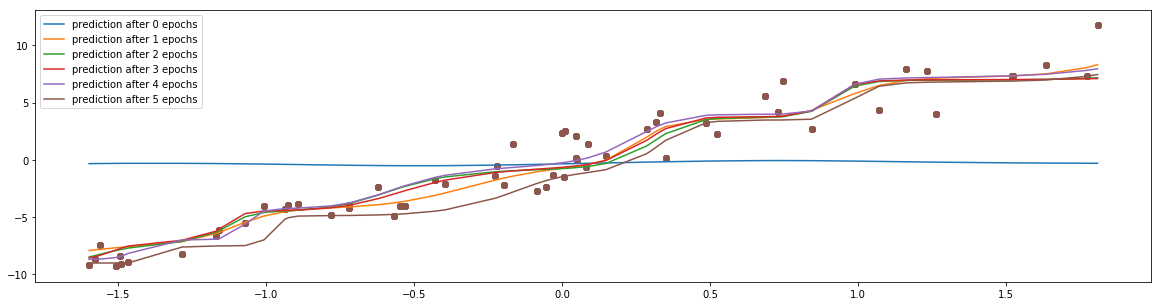

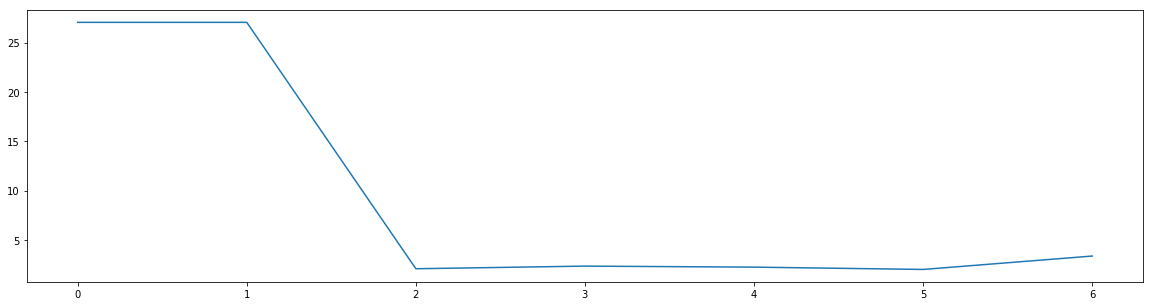

In [9]:
net = EnsembleNetwork(num_epochs = num_epochs,learning_rate=learning_rate,adversarial=False,num_neurons=num_neurons)
visualise(net,num_meta_epochs = num_meta_epochs)

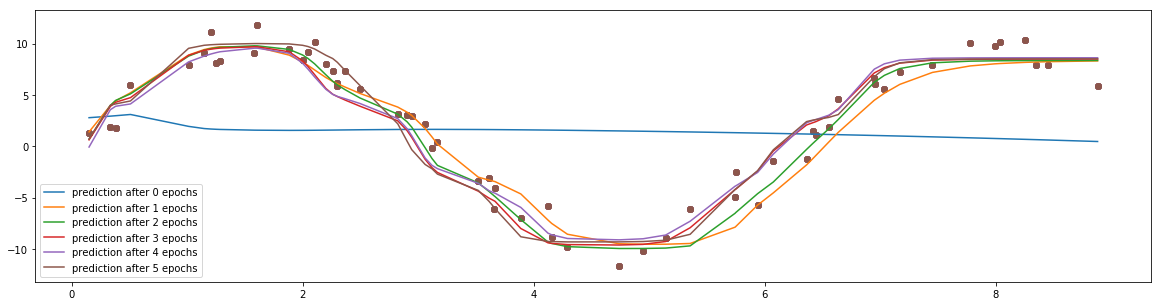

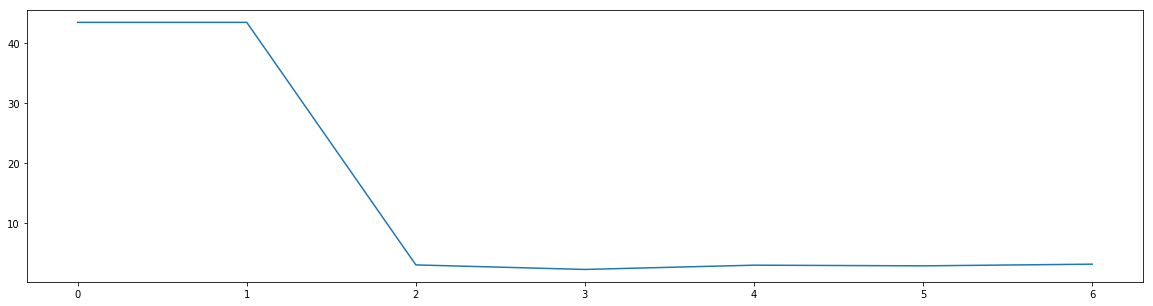

In [10]:
net2 = EnsembleNetwork(num_epochs = num_epochs,learning_rate=learning_rate,adversarial=False,num_neurons=num_neurons)
visualise(net2,num_meta_epochs = num_meta_epochs,
                      X_train=X_train_nonlinear,X_test=X_test_nonlinear,y_train=y_train_nonlinear,y_test=y_test_nonlinear,
          test_idx=test_idx_nonlinear,train_idx=train_idx_nonlinear)

# dropout Network

In [11]:


class DropoutNetwork(EnsembleNetwork):
    def __init__(
            self,
            num_neurons=[10, 10],
            num_features=1,
            learning_rate=0.001,
            activations=None,  #[tf.nn.tanh,tf.nn.relu,tf.sigmoid]
            dropout_layers=None,  #[True,False,True]
            initialisation_scheme=None,  #[tf.random_normal,tf.random_normal,tf.random_normal]
            optimizer=None,  #defaults to GradiendDescentOptimizer,
            num_epochs=None,  #defaults to 1,
            seed=None,
            adversarial=None):

            super(DropoutNetwork, self).__init__(num_neurons,num_features,learning_rate,activations,
                                                 dropout_layers,initialisation_scheme,optimizer,num_epochs,seed,adversarial)

    @lazy_property
    def predict_graph(self):
        #set layer_input to input
        layer_input = self.X

        #for each layer do
        for i, w in enumerate(self.w_list):

            #z = input x Weights
            a = tf.matmul(layer_input, w, name='matmul_' + str(i))
            if i == self.num_layers:
                a = tf.nn.dropout(a, 0.90) #0.9 = keep_prob

            #z + bias
            if i < self.num_layers:
                bias = self.b_list[i]
                a = tf.add(a, bias)

            #a = sigma(z) if not last layer and regression
            if i < self.num_layers:

                a = self.activations[i](a)
            #set layer input to a for next cycle
    
            layer_input = a

        return a
    
    def predict(self, X):
        X = self.check_input_dimensions(X)
        
        pred_list = [self.session.run(self.predict_graph, feed_dict={self.X: X}).squeeze() for i in range(15)]
        
        pred_mean = np.mean(pred_list,axis=0)
        #pred_std = np.std(pred_list,axis=0)
        return pred_mean#, pred_std
    
    def get_mean_and_std(self, X):
        X = self.check_input_dimensions(X)
        
        pred_list = [self.session.run(self.predict_graph, feed_dict={self.X: X}).squeeze() for i in range(15)]
        
        pred_mean = np.mean(pred_list,axis=0)
        pred_std = np.std(pred_list,axis=0)
        return pred_mean, pred_std


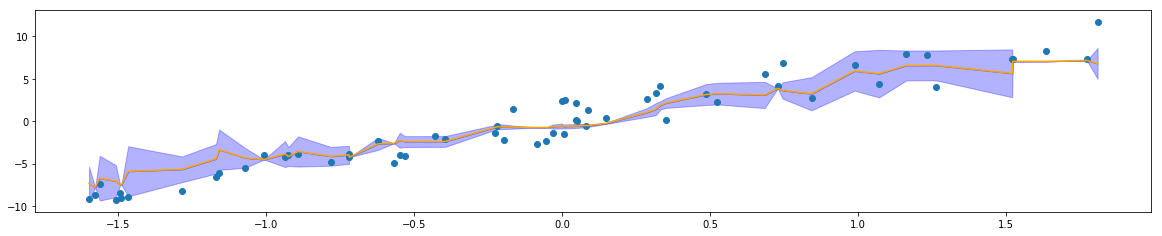

In [12]:
dropnet = DropoutNetwork(num_epochs = num_epochs,learning_rate=learning_rate,adversarial=False,num_neurons=num_neurons)
visualise_uncertainty(dropnet,num_meta_epochs = num_meta_epochs,plot=False)

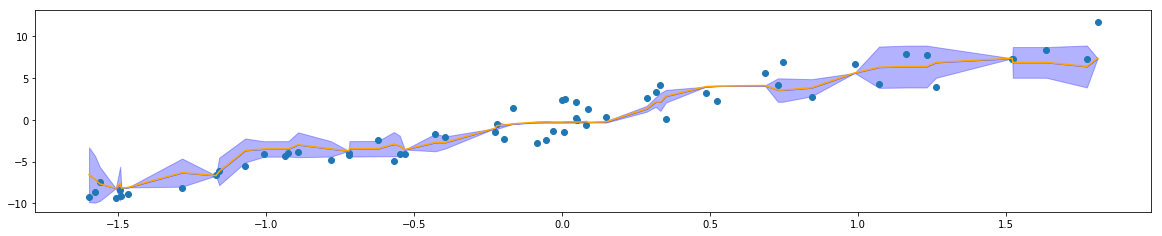

In [13]:
dropnet = DropoutNetwork(num_epochs = num_epochs,learning_rate=learning_rate,adversarial=True,num_neurons=num_neurons)
visualise_uncertainty(dropnet,num_meta_epochs = num_meta_epochs,plot=False)

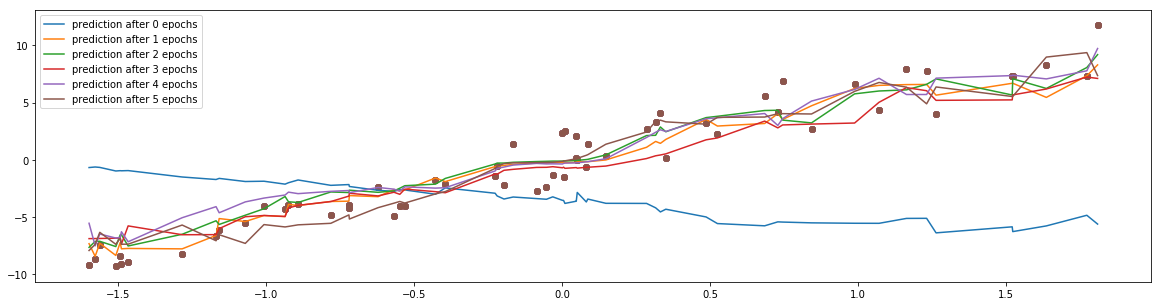

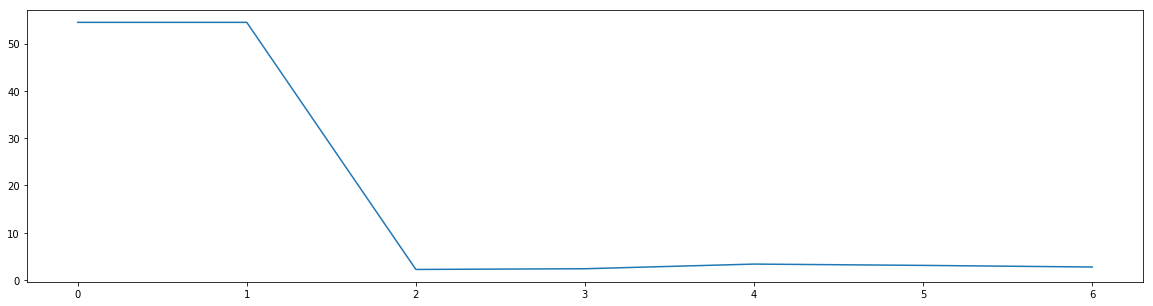

In [14]:
dropnet = DropoutNetwork(num_epochs = num_epochs,learning_rate=learning_rate,adversarial=False,num_neurons=num_neurons)
visualise(dropnet,num_meta_epochs = num_meta_epochs)

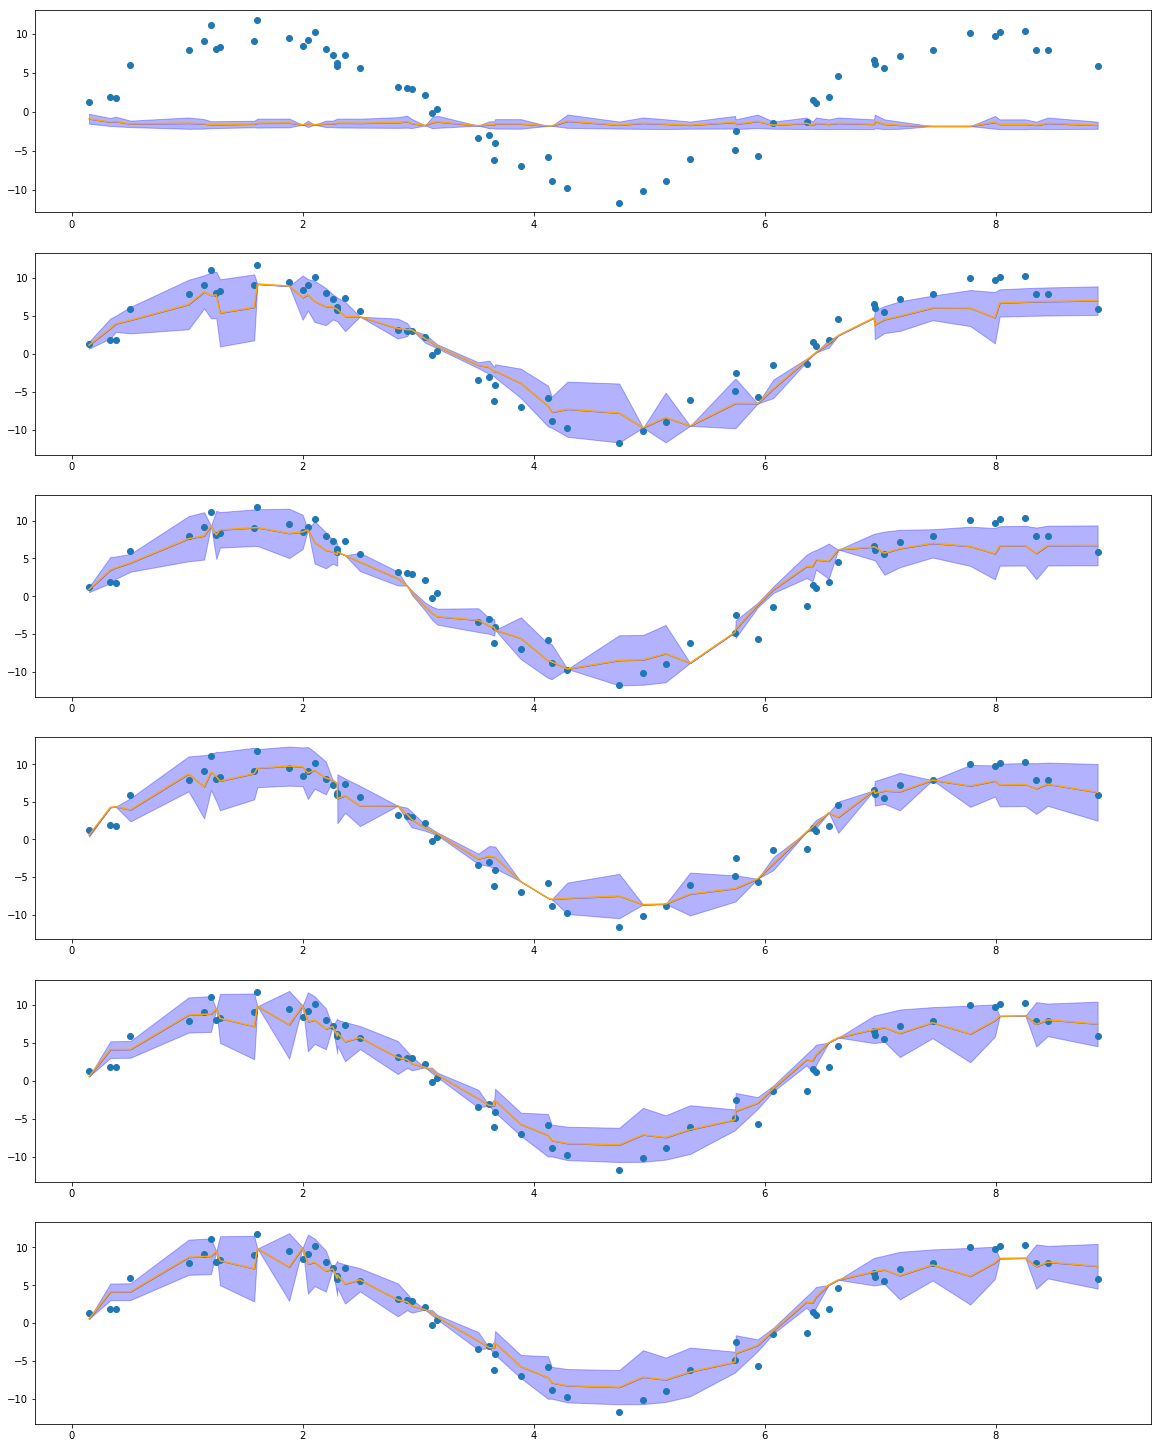

In [15]:
dropnet2 = DropoutNetwork(num_epochs = num_epochs,learning_rate=learning_rate,adversarial=False,num_neurons=num_neurons)

visualise_uncertainty(dropnet2,num_meta_epochs = num_meta_epochs,
                      X_train=X_train_nonlinear,X_test=X_test_nonlinear,y_train=y_train_nonlinear,y_test=y_test_nonlinear,
          test_idx=test_idx_nonlinear,train_idx=train_idx_nonlinear)

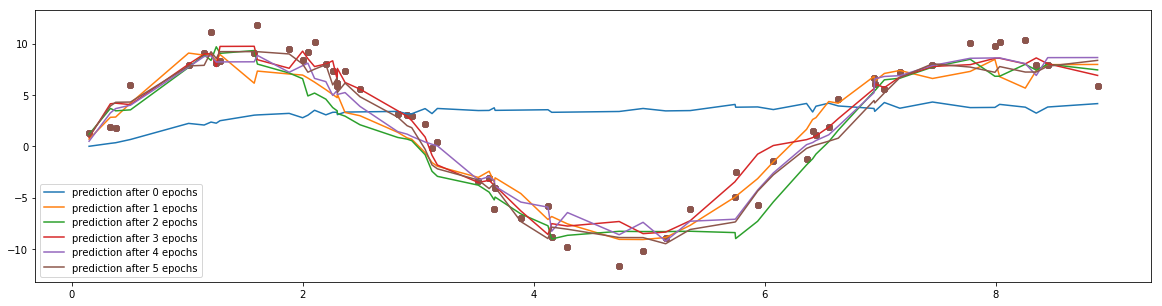

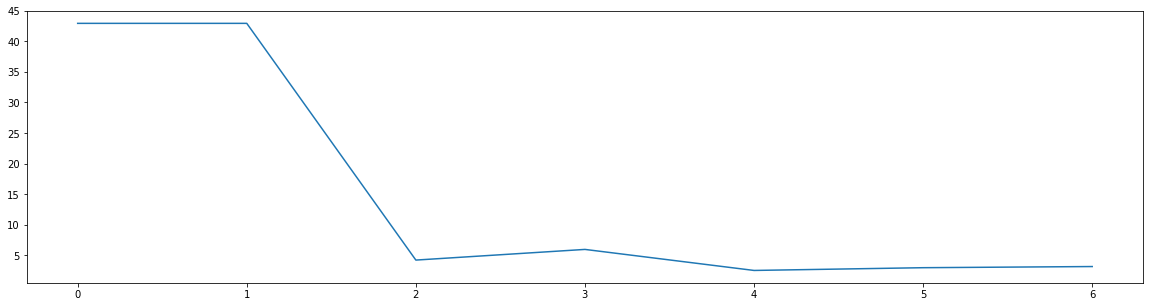

In [16]:
dropnet2 = DropoutNetwork(num_epochs = num_epochs,learning_rate=learning_rate,adversarial=False,num_neurons=num_neurons)

visualise(dropnet2,num_meta_epochs = num_meta_epochs,
                      X_train=X_train_nonlinear,X_test=X_test_nonlinear,y_train=y_train_nonlinear,y_test=y_test_nonlinear,
          test_idx=test_idx_nonlinear,train_idx=train_idx_nonlinear)

# NLPD Network

In [17]:


class NlpdNetwork(EnsembleNetwork):
    def __init__(
            self,
            num_neurons=[10,5,5,5, 5],
            num_features=1,
            learning_rate=0.001,
            activations=None,  #[tf.nn.tanh,tf.nn.relu,tf.sigmoid]
            dropout_layers=None,  #[True,False,True]
            initialisation_scheme=None,  #[tf.random_normal,tf.random_normal,tf.random_normal]
            optimizer=None,  #defaults to GradiendDescentOptimizer,
            num_epochs=None,  #defaults to 1,
            seed=None,
            adversarial=None):

        #necessary parameters
        self.num_neurons = num_neurons
        self.num_layers = len(num_neurons)
        self.num_features = num_features
        self.learning_rate = learning_rate
        self.adversarial = adversarial or ADVERSARIAL

        #optional parameters
        self.optimizer = optimizer or tf.train.AdamOptimizer#tf.train.GradientDescentOptimizer
        self.activations = activations or [tf.nn.relu] * self.num_layers #tanh,relu, 
        self.initialisation_scheme = initialisation_scheme or tf.random_uniform#tf.truncated_normal#
        self.num_epochs = num_epochs or 10
        self.seed = seed or None

        #initialise graph
        self.g = tf.Graph()
        #build graph with self.graph as default so nodes get appended
        with self.g.as_default():
            self.init_network
            self.predict_graph
            self.p_graph
            self.std_graph
            self.error_graph
            self.train_graph
            self.init = tf.global_variables_initializer()

        #initialise session
        self.session = tf.Session(graph=self.g)
        #initialise global variables
        self.session.run(self.init)
    @lazy_property
    def init_network(self):
        self.min_std = tf.Variable(0.05)

        if self.seed:
            tf.set_random_seed(self.seed)
        #inputs
        self.X = tf.placeholder(tf.float32, (None, self.num_features))
        self.y = tf.placeholder(tf.float32, (None, 1))  #regression = 1

        #lists for storage
        self.w_list = []
        self.b_list = []

        #add input x first weights
        self.w_list.append(
            tf.Variable(
                self.initialisation_scheme(
                    [self.num_features, self.num_neurons[0]]),
                name='w_0'))  #first Matrix

        #for each layer over 0 add a n x m matrix and a bias term
        for i, num_neuron in enumerate(self.num_neurons[1:]):
            n_inputs = self.num_neurons[i]  #for first hidden layer 3
            n_outputs = self.num_neurons[i + 1]  #for first hidden layer 5

            self.w_list.append(
                tf.Variable(
                    self.initialisation_scheme([n_inputs, n_outputs]),
                    name='w_' + str(i)))
            self.b_list.append(
                tf.Variable(tf.ones(shape=[n_inputs]), name='b_' + str(i)))

        #add last layer m  x 1 for output
        self.p_w = tf.Variable(
            self.initialisation_scheme([self.num_neurons[-1], 1]),
            name='w_-1')  #this is a regression
        self.std_w = tf.Variable(
            self.initialisation_scheme([self.num_neurons[-1], 1]),
            name='w_std')  #this is a regression

        self.b_list.append(
            tf.Variable(
                tf.ones(shape=[self.num_neurons[-1]]), name='b_' + str(
                    len(self.num_neurons) + 1)))

    @lazy_property
    def predict_graph(self):
        #set layer_input to input
        layer_input = self.X

        #for each layer do
        for i, w in enumerate(self.w_list):

            #z = input x Weights
            a = tf.matmul(layer_input, w, name='matmul_' + str(i))

            #z + bias
            #if i < self.num_layers:
            bias = self.b_list[i]
            a = tf.add(a, bias)

            #a = sigma(z) if not last layer and regression
            #if i < self.num_layers:    

            a = self.activations[i](a)

            #set layer input to a for next cycle
            layer_input = a

        return a

    @lazy_property
    def p_graph(self):
        l_in = self.predict_graph
        return tf.matmul(l_in, self.p_w)

    @lazy_property
    def std_graph(self):
        l_in = self.predict_graph
        return tf.nn.softplus(tf.matmul(l_in, self.std_w)) 
    @lazy_property
    def error_graph(self):

        #y_hat is a // output of prediction graph
        y_hat = self.p_graph
        std_hat = tf.maximum(self.std_graph, self.min_std)  #tf.square(self.std_graph)

        #first_term = tf.log(tf.div(std_hat, 2.0))
        first_term = tf.log(std_hat)
        second_term = tf.div(
            tf.square(tf.subtract(self.y, y_hat)),  std_hat)
        error = tf.add(tf.add(first_term, second_term), 1.0)

        return error


    def predict(self, X):
        return self.session.run(self.p_graph, feed_dict={self.X: X})#, self.session.run(self.std_graph, feed_dict={self.X: X})

    def predict_var(self, X):
        return self.session.run(self.std_graph, feed_dict={self.X: X})

                                
    def get_mean_and_std(self, X):
        return self.session.run(self.p_graph, feed_dict={self.X: X}), self.session.run(self.std_graph, feed_dict={self.X: X})


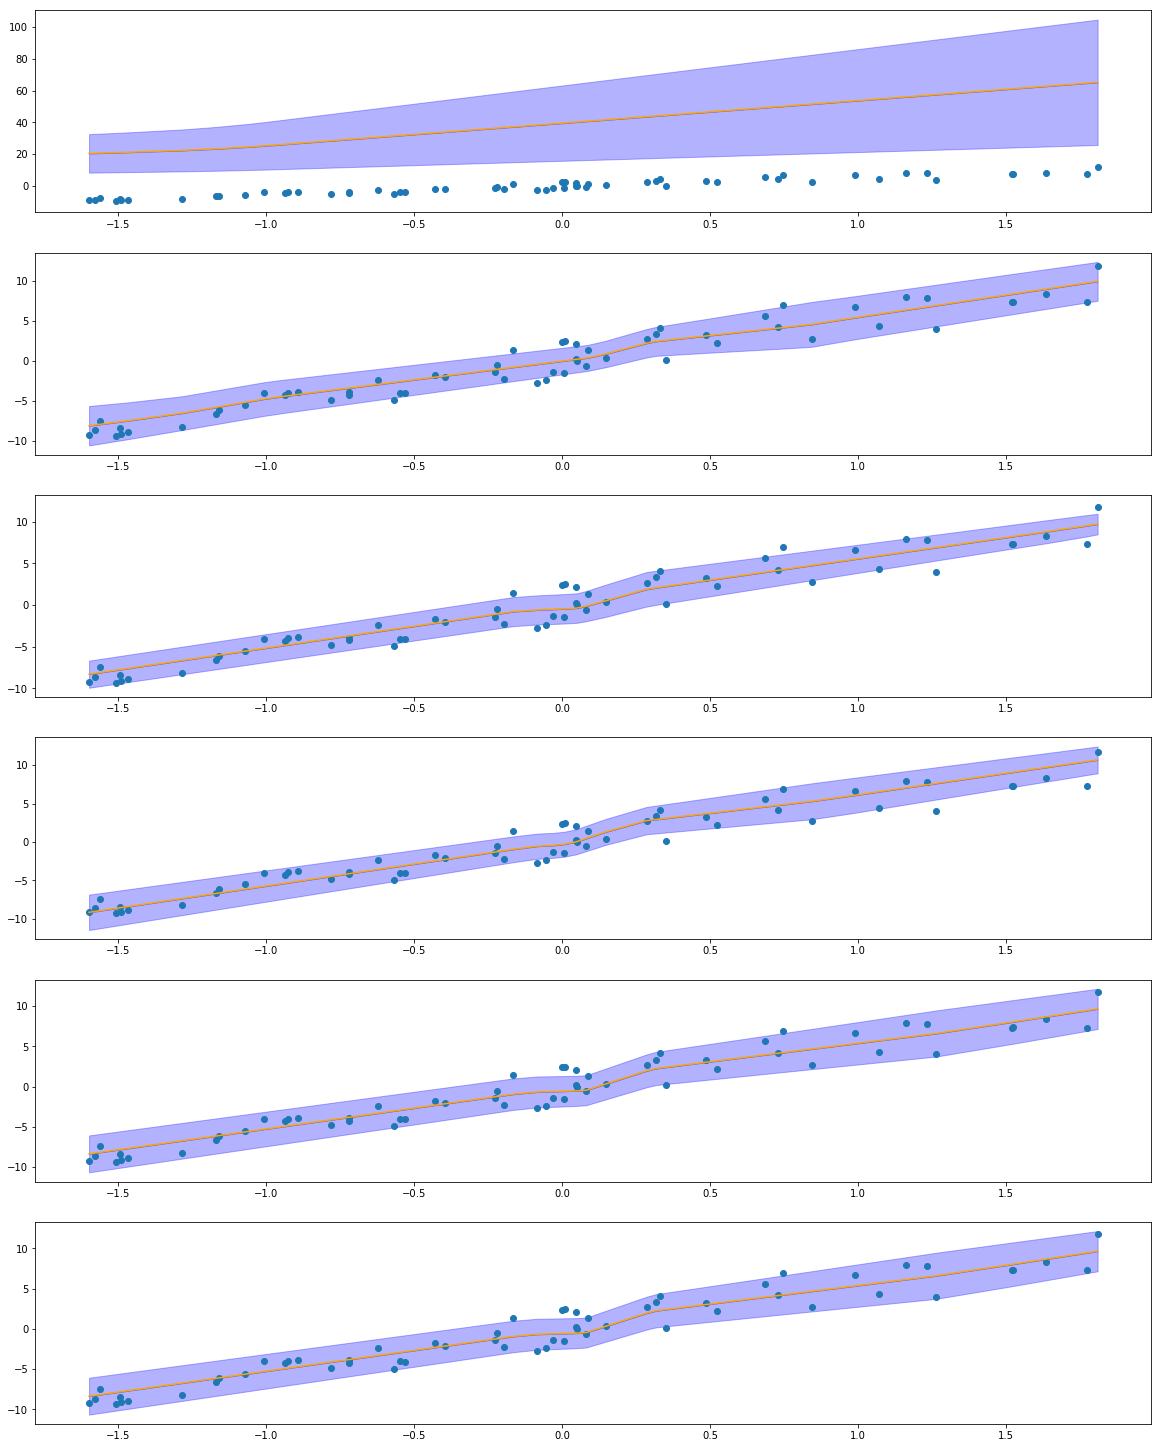

In [18]:
nlpd = NlpdNetwork(num_epochs = num_epochs,learning_rate=learning_rate,adversarial=False,num_neurons=num_neurons)
visualise_uncertainty(nlpd,num_meta_epochs = num_meta_epochs,plot=True)

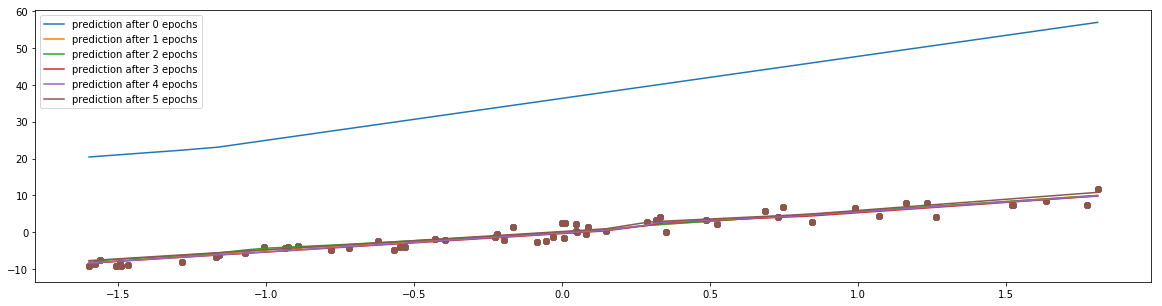

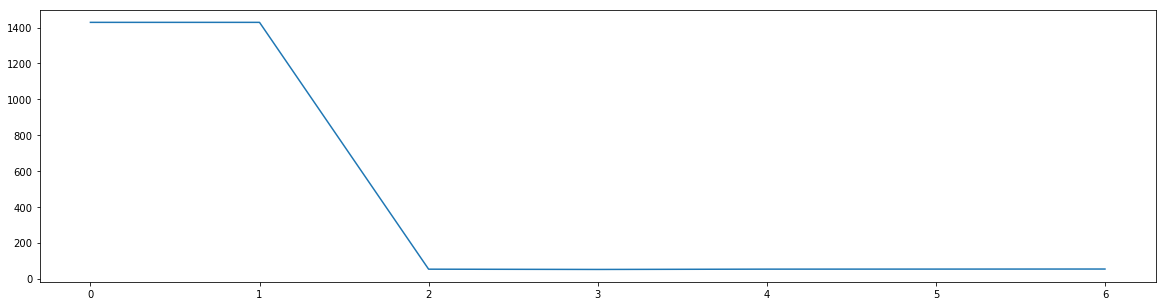

In [19]:
nlpd = NlpdNetwork(num_epochs = num_epochs,learning_rate=learning_rate,adversarial=False,num_neurons=num_neurons)
visualise(nlpd,num_meta_epochs = num_meta_epochs)

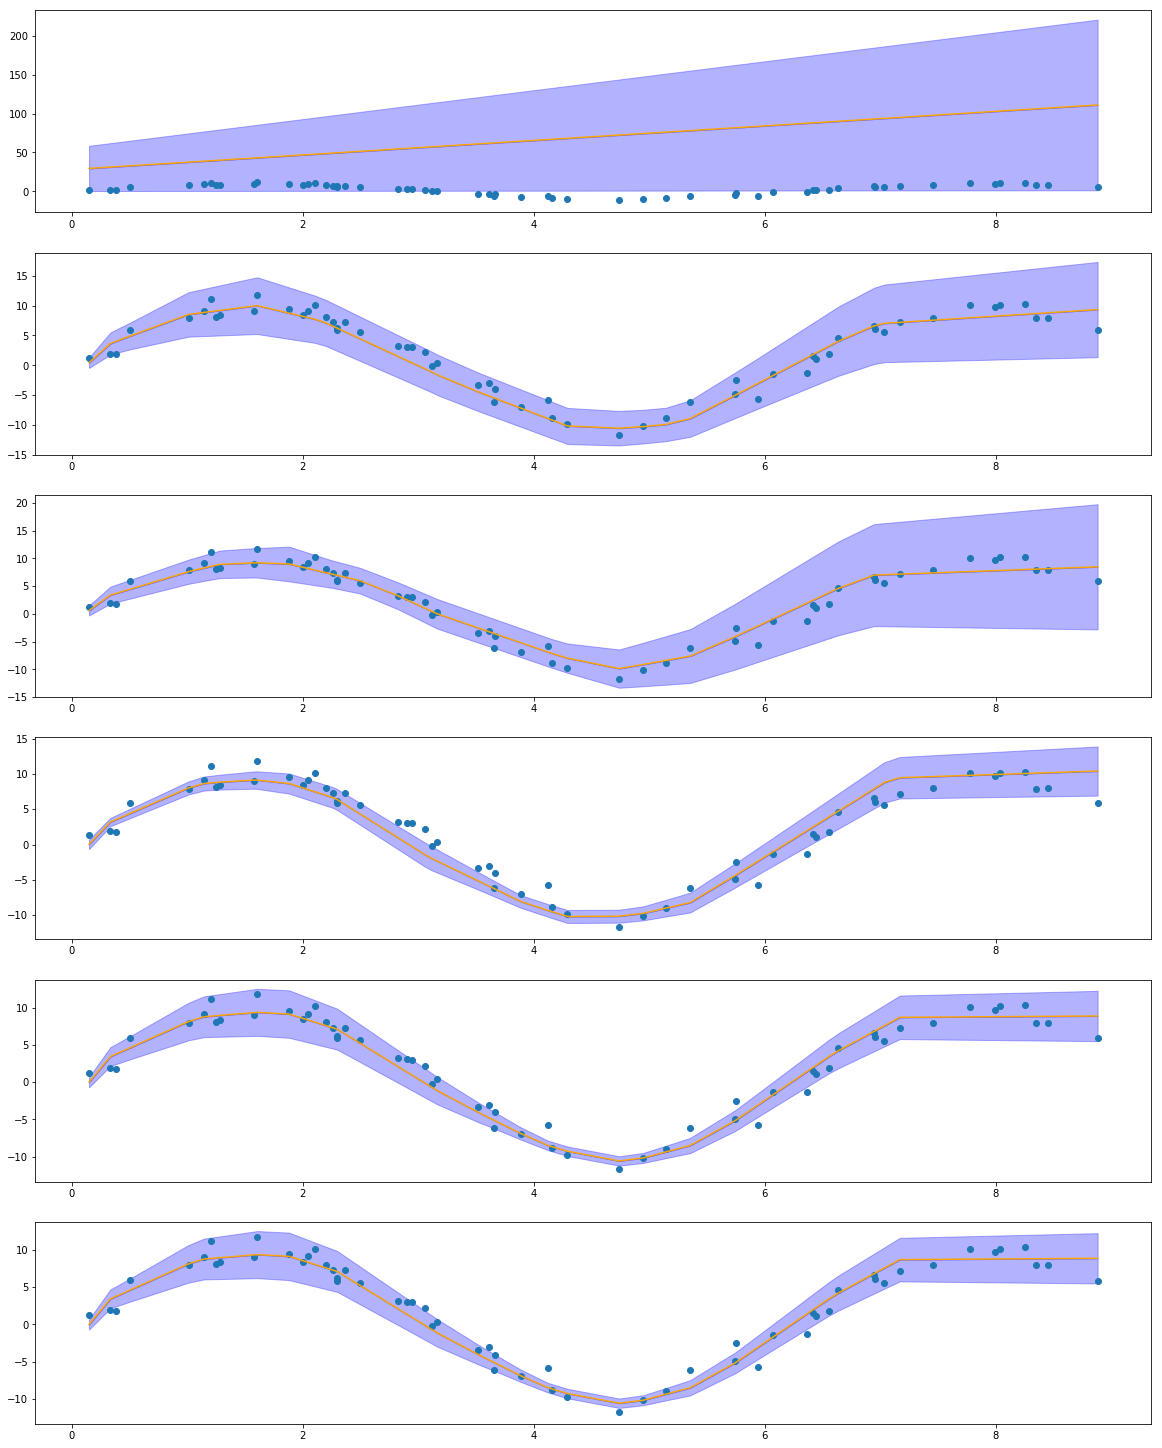

In [20]:
nlpd2 = NlpdNetwork(num_epochs = num_epochs,learning_rate=learning_rate,adversarial=False,num_neurons=num_neurons)

visualise_uncertainty(nlpd2,num_meta_epochs = num_meta_epochs,
                      X_train=X_train_nonlinear,X_test=X_test_nonlinear,y_train=y_train_nonlinear,y_test=y_test_nonlinear,
          test_idx=test_idx_nonlinear,train_idx=train_idx_nonlinear)

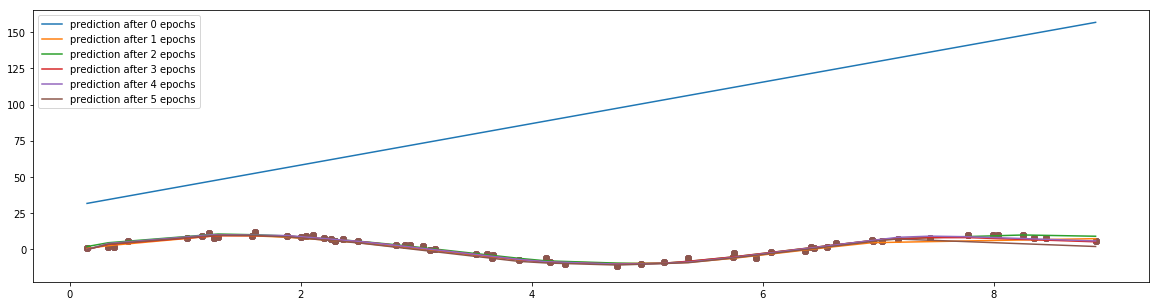

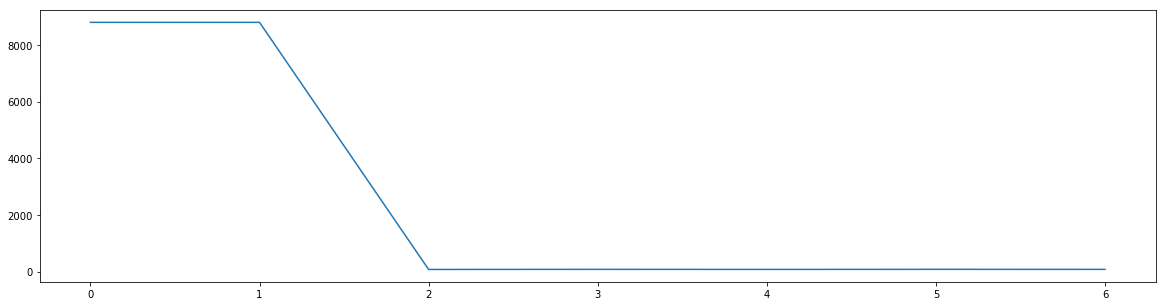

In [21]:
nlpd3 = NlpdNetwork(num_epochs = num_epochs,learning_rate=learning_rate,adversarial=False,num_neurons=num_neurons)

visualise(nlpd3,num_meta_epochs = num_meta_epochs,
                      X_train=X_train_nonlinear,X_test=X_test_nonlinear,y_train=y_train_nonlinear,y_test=y_test_nonlinear,
          test_idx=test_idx_nonlinear,train_idx=train_idx_nonlinear)